In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torchvision import datasets

In [2]:
#Load MNIST Data formatting ToTensor
train = datasets.MNIST('data', download=True, train=True, transform=transforms.ToTensor())
test = datasets.MNIST('data', download=True, train=False, transform=transforms.ToTensor())

In [3]:
num_batch = 32
train_loader = DataLoader(train, batch_size=num_batch, shuffle=True)
test_loader = DataLoader(test, batch_size=num_batch, shuffle=False)

In [4]:
#Check Data Shape
for images, labels in train_loader:
    print(images.size())
    print(images[0].size())
    print(labels.size())
    break

torch.Size([32, 1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([32])


In [5]:
#Define Model for SGD, dropout=0.25
class NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(28*28, 10)
        self.dropout = nn.Dropout2d(0.25)
        
    def forward(self, x):
        x = self.dropout(x)
        x = F.relu(self.fc(x))
        return x


In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = NN().to(device)

#Use CrossEntropyLoss
criterion = nn.CrossEntropyLoss()
#Use SGD, learning rate=0.001
optimizer = optim.SGD(model.parameters(), lr=0.0001)

In [21]:
num_epoch = 100

train_ac_list = []
train_loss_list = []
test_ac_list = []
test_loss_list = []
test_p_list = []
test_r_list = []
test_f1_list = []

for i in range(num_epoch):
    train_ac = 0
    train_loss = 0
    test_ac = 0
    test_loss = 0
    tp = 0
    tn = 0
    fn = 0
    fp = 0
    
    model.train()
    
    for image, label in train_loader:
        image = image.view(-1, 28*28).to(device)
        label = label.to(device)
        
        #Zero grad
        optimizer.zero_grad()
        #Forward
        output = model(image)
        
        #Loss
        loss = criterion(output, label)
        train_loss += loss.item()
        
        #Softmax Layer
        y_prob = nn.Softmax(dim=1)(output)
        y_pred = torch.argmax(y_prob, dim=1)
        #Accuracy
        train_ac += (y_pred.eq(label).float()).sum().item()
        
        #Backward
        loss.backward()
        #Update param
        optimizer.step()
    
    avg_train_loss = train_loss / len(train_loader.dataset)
    avg_train_ac = train_ac / len(train_loader.dataset)

    model.eval()
    with torch.no_grad():
        for image, label in test_loader:
            image = image.view(-1, 28*28).to(device)
            label = label.to(device)

            output = model(image)
        
            #Loss
            loss = criterion(output, label)
            test_loss += loss.item()
        
            #Softmax Layer
            y_prob = nn.Softmax(dim=1)(output)
            #Accuracy
            y_pred = torch.argmax(y_prob, dim=1)
            test_ac += (y_pred.eq(label).float()).sum().item()

            for pred, label in zip(y_pred, label):
                if pred==label:
                    if pred==True:
                        tp+=1
                    else:
                        tn+=1
                elif pred==False:
                    fn+=1
                elif pred==True:
                    fp+=1
                        
    avg_test_loss = test_loss / len(test_loader.dataset)
    #Accuracy
    avg_test_ac = test_ac / len(test_loader.dataset)
    #Precision
    test_p = tp/(tp+fp)
    #Recall
    test_r = tp/(tp+fn)
    #F1-score
    test_f1 = 2*test_p*test_r / (test_p+test_r)
            
    
    if (i+1)%10 == 0:
        print ('Epoch: {}, Train_Accuracy: {train_ac:.4f}, Train_Loss: {train_loss:.4f}, Test_Accuracy: {test_ac:.4f}, Test_Loss: {test_loss:.4f}, Precision: {test_p:.4f}, Recall: {test_r:.4f}, F1: {test_f1:.4f}' .format(i+1, train_ac=avg_train_ac, train_loss=avg_train_loss, test_ac=avg_test_ac, test_loss=avg_test_loss, test_p=test_p, test_r=test_r, test_f1=test_f1))
    
    train_ac_list.append(avg_train_ac)
    train_loss_list.append(avg_train_loss)
    test_ac_list.append(avg_test_ac)
    test_loss_list.append(avg_test_loss)
    test_p_list.append(test_p)
    test_r_list.append(test_r)
    test_f1_list.append(test_f1)


Epoch: 10, Train_Accuracy: 0.7044, Train_Loss: 0.0448, Test_Accuracy: 0.7379, Test_Loss: 0.0433, Precision: 0.7502, Recall: 0.7543, F1: 0.7522
Epoch: 20, Train_Accuracy: 0.7416, Train_Loss: 0.0363, Test_Accuracy: 0.7655, Test_Loss: 0.0349, Precision: 0.8007, Recall: 0.8403, F1: 0.8200
Epoch: 30, Train_Accuracy: 0.7542, Train_Loss: 0.0323, Test_Accuracy: 0.7751, Test_Loss: 0.0309, Precision: 0.8243, Recall: 0.8532, F1: 0.8385
Epoch: 40, Train_Accuracy: 0.7624, Train_Loss: 0.0299, Test_Accuracy: 0.7821, Test_Loss: 0.0284, Precision: 0.8422, Recall: 0.8621, F1: 0.8520
Epoch: 50, Train_Accuracy: 0.7681, Train_Loss: 0.0283, Test_Accuracy: 0.7881, Test_Loss: 0.0268, Precision: 0.8508, Recall: 0.8670, F1: 0.8588
Epoch: 60, Train_Accuracy: 0.7716, Train_Loss: 0.0271, Test_Accuracy: 0.7919, Test_Loss: 0.0256, Precision: 0.8636, Recall: 0.8697, F1: 0.8666
Epoch: 70, Train_Accuracy: 0.7756, Train_Loss: 0.0262, Test_Accuracy: 0.7945, Test_Loss: 0.0247, Precision: 0.8746, Recall: 0.8690, F1: 0.8718

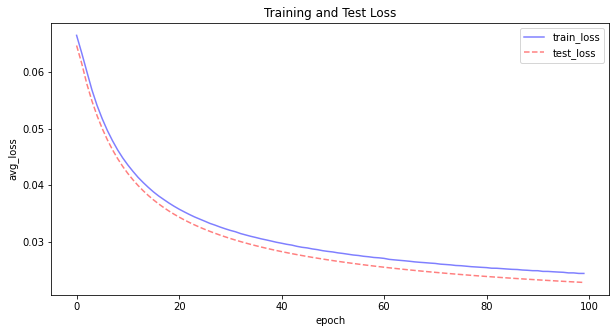

In [22]:
#Plot
plt.figure(figsize=[10,5])
plt.plot(np.arange(0, num_epoch), train_loss_list, color='blue', linestyle='-', label='train_loss', alpha=0.5)
plt.plot(np.arange(0, num_epoch), test_loss_list, color='red', linestyle='--', label='test_loss', alpha=0.5)
plt.legend()
plt.title("Training and Test Loss")
plt.xlabel("epoch")
plt.ylabel("avg_loss")
plt.show()


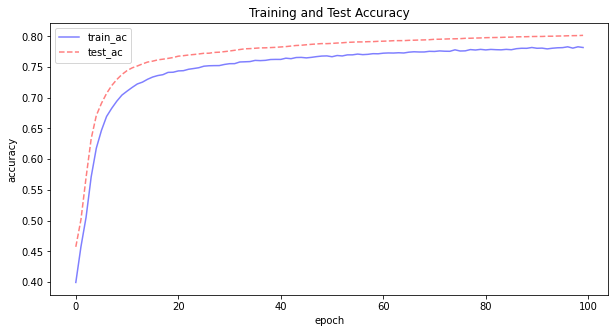

In [23]:
#Plot
plt.figure(figsize=[10,5])
plt.plot(np.arange(0, num_epoch), train_ac_list, color='blue', linestyle='-', label='train_ac', alpha=0.5)
plt.plot(np.arange(0, num_epoch), test_ac_list, color='red', linestyle='--', label='test_ac', alpha=0.5)
plt.legend()
plt.title("Training and Test Accuracy")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.show()


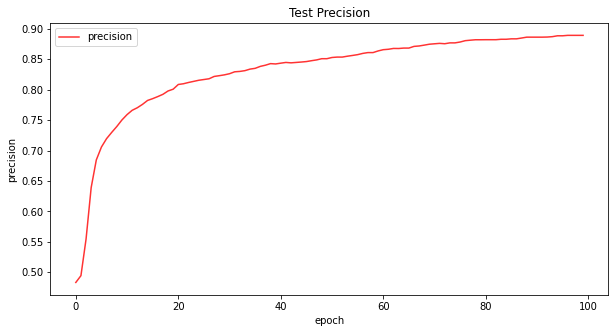

In [24]:
#Plot
plt.figure(figsize=[10,5])
plt.plot(np.arange(0, num_epoch), test_p_list, color='red', linestyle='-', label='precision', alpha=0.8)
plt.legend()
plt.title("Test Precision")
plt.xlabel("epoch")
plt.ylabel("precision")
plt.show()


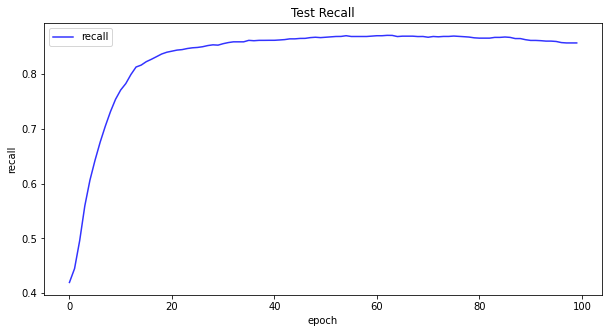

In [25]:
#Plot
plt.figure(figsize=[10,5])
plt.plot(np.arange(0, num_epoch), test_r_list, color='blue', linestyle='-', label='recall', alpha=0.8)
plt.legend()
plt.title("Test Recall")
plt.xlabel("epoch")
plt.ylabel("recall")
plt.show()


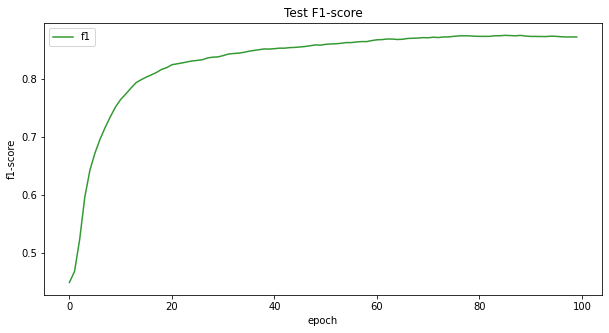

In [26]:
#Plot
plt.figure(figsize=[10,5])
plt.plot(np.arange(0, num_epoch), test_f1_list, color='Green', linestyle='-', label='f1', alpha=0.8)
plt.legend()
plt.title("Test F1-score")
plt.xlabel("epoch")
plt.ylabel("f1-score")
plt.show()



Predict


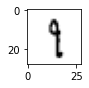

true_label: 9, y_pred: 1



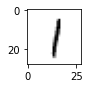

true_label: 1, y_pred: 1



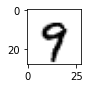

true_label: 9, y_pred: 9



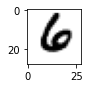

true_label: 6, y_pred: 6



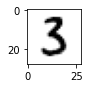

true_label: 3, y_pred: 5



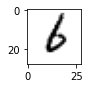

true_label: 6, y_pred: 6



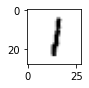

true_label: 1, y_pred: 1



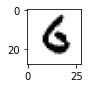

true_label: 6, y_pred: 6



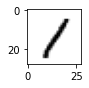

true_label: 1, y_pred: 1



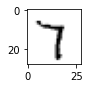

true_label: 7, y_pred: 7



In [27]:
#Predict Sample 10 examples from MNIST
print("\nPredict")

idx = np.random.choice(10000, 10)

for i in idx:
    output = model(Variable(torch.from_numpy(np.array(test.data[i].view(-1, 28*28), dtype="float32"))))
    y_pred = torch.argmax(output, dim=1)
    
    plt.figure(figsize=(1, 1))
    plt.imshow(test.data[i].reshape(28,28), cmap=plt.cm.gray_r)
    plt.show()
    print("true_label: {}, y_pred: {}\n".format(test.targets[i], y_pred[0]))
